In [173]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from keras.preprocessing import image
from sklearn.utils import shuffle 
import cv2
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [189]:
target_size = (1024, 512)
initial_size = ()
input_dir = "../VITON_traindata/train_color"
edge_dir = "../VITON_traindata/train_edge"


# Function to load and preprocess an image
def load_and_preprocess_image(image_path, conversion_mode="RGB"):
    img = Image.open(image_path)
    img = img.convert(conversion_mode)
    initial_size = np.array(img).shape
    img = img.resize(target_size[::-1], Image.Resampling.LANCZOS)
    # img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    # img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255  # Normalize pixel values to between 0 and 1
    return img_array, initial_size

def postprocess_image(image):
    image = np.squeeze(image, 0)
    print(image.shape)
    image = image[:, :, 0]
    print(image.shape)
    print(image.max(), image.min())
    image = (image > 0.66).astype("uint8")
    print(np.unique(image, return_counts=True))
    # print(image.max(), image.min())
    # print(image)
    image = image * 255
    print(image.shape)
    # image = np.where(image > 127.5, 255, 0) 
    print(image.max(), image.min())
    print(np.unique(image, return_counts=True))
    # print(image)
    image = Image.fromarray(image) 
    image = image.resize([initial_size[1], initial_size[0]], Image.Resampling.LANCZOS)
    return image

input_person_image, initial_size = load_and_preprocess_image('person_image.png')  # Replace with the actual path

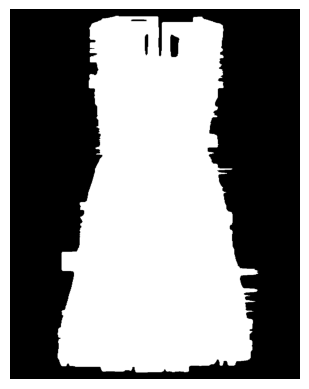

In [190]:
obj = np.squeeze(result, 0)
obj = np.squeeze(obj, 2)
# grayscale = np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])

# Step 2: Apply Threshold
# Define a threshold value
obj = obj * 255
threshold = 160  # This value is adjustable depending on how you define "black" and "white"
black_and_white = np.where(obj > threshold, 255, 0)

# Convert back to an unsigned 8-bit integer type if needed
black_and_white = black_and_white.astype(np.uint8)
black_and_white = black_and_white * 255
black_and_white = Image.fromarray(black_and_white)
black_and_white = black_and_white.resize([initial_size[1], initial_size[0]], resample=Image.Resampling.LANCZOS)

# Display the black and white image
plt.imshow(black_and_white, cmap='gray')
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

(1024, 512, 1)
(1024, 512)
0.7145586 0.4106984
(array([0, 1], dtype=uint8), array([302941, 221347]))
(1024, 512)
255 0
(array([  0, 255], dtype=uint8), array([302941, 221347]))


(-0.5, 1023.5, 1308.5, -0.5)

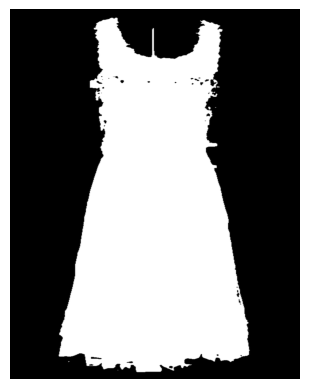

In [191]:
plt.imshow(postprocess_image(result), cmap="gray");
plt.axis("off")

In [160]:
result[0,0,0,:]

array([0.49390805], dtype=float32)

In [116]:
initial_size



(1309, 1024, 3)

('../VITON_traindata/train_color', [], ['011464_1.jpg', '014202_1.jpg', '001172_1.jpg', '004714_1.jpg', '016937_1.jpg', '001931_1.jpg', '003204_1.jpg', '016174_1.jpg', '013712_1.jpg', '003690_1.jpg', '014696_1.jpg', '004380_1.jpg', '016972_1.jpg', '004751_1.jpg', '001137_1.jpg', '006427_1.jpg', '013757_1.jpg', '005714_1.jpg', '000172_1.jpg', '002204_1.jpg', '007462_1.jpg', '017174_1.jpg', '010421_1.jpg', '000137_1.jpg', '005751_1.jpg', '017972_1.jpg', '007427_1.jpg', '002241_1.jpg', '017131_1.jpg', '012757_1.jpg', '012386_1.jpg', '015696_1.jpg', '005380_1.jpg', '018709_1.jpg', '008532_1.jpg', '017288_1.jpg', '010798_1.jpg', '018061_1.jpg', '008577_1.jpg', '005039_1.jpg', '010349_1.jpg', '017659_1.jpg', '002529_1.jpg', '013839_1.jpg', '009532_1.jpg', '004039_1.jpg', '011349_1.jpg', '016659_1.jpg', '003529_1.jpg', '016288_1.jpg', '016275_1.jpg', '013413_1.jpg', '006763_1.jpg', '003105_1.jpg', '014940_1.jpg', '003946_1.jpg', '001273_1.jpg', '011765_1.jpg', '013881_1.jpg', '009918_1.jpg', 

(-0.5, 191.5, 255.5, -0.5)

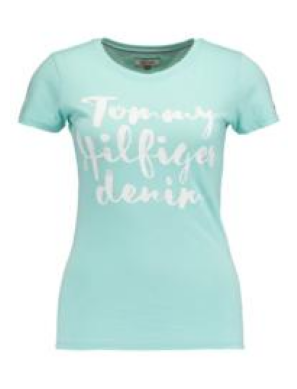

In [4]:
for item in os.walk("../VITON_traindata/train_color"):
    print(item)
img = Image.open("../VITON_traindata/train_color/004419_1.jpg")
plt.imshow(img);
plt.axis("off")

In [14]:


# Define U-Net model architecture
def unet_model(num_classes):
    person_input = Input(shape=(target_size[0], target_size[1], 3))

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(person_input)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottom layer
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Decoder
    up5 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)

    # Output layer
    outputs = Conv2D(1, 1, activation='sigmoid')(conv7)

    model = Model(inputs=person_input, outputs=outputs)
    return model

# Example usage
num_classes = 7  # Number of body parts classes (adjust as needed)

model = unet_model(num_classes)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1024, 512, 3)]       0         []                            
                                                                                                  
 conv2d_15 (Conv2D)          (None, 1024, 512, 64)        1792      ['input_2[0][0]']             
                                                                                                  
 conv2d_16 (Conv2D)          (None, 1024, 512, 64)        36928     ['conv2d_15[0][0]']           
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 512, 256, 64)         0         ['conv2d_16[0][0]']           
 g2D)                                                                                       

In [15]:
lr = 0.002
beta1, beta2 = 0.5, 0.999
model_optimizer = Adam(lr, beta_1 = beta1, beta_2 = beta2)

In [7]:
input_image_names = sorted([file for _, _, item in os.walk(input_dir) for file in item])
input_image_names = input_image_names[:100]
edge_image_names = sorted([file for _, _, item in os.walk(edge_dir) for file in item])
edge_image_names = edge_image_names[:100]

In [8]:
input_images = [load_and_preprocess_image(os.path.join(input_dir, item)) for item in input_image_names]
edge_images = [load_and_preprocess_image(os.path.join(edge_dir, item), "L") for item in edge_image_names]

In [9]:
model.fit(np.array(input_images), np.array(edge_images), epochs=3)

Epoch 1/3
4/4 [==============================] - 999s 217s/step - loss: 0.2561
Epoch 2/3
4/4 [==============================] - 909s 201s/step - loss: 0.2329
Epoch 3/3
4/4 [==============================] - 893s 197s/step - loss: 0.2228


In [10]:
model.save_weights('model_unet.h5')

In [78]:
model.load_weights("model_unet.h5")
test_image, _ = load_and_preprocess_image("dress_image.png")
print(test_image.shape)
result = model.predict(np.expand_dims(test_image, 0))

(1024, 512, 3)
1/1 [==============================] - 2s 2s/step


In [119]:
obj = np.squeeze(result, 0)
# obj = (obj > 0.5).astype("uint8")
# print(np.unique(obj, return_counts=True))
obj = obj * 255
image = Image.fromarray(obj)
print(np.unique(obj, return_counts=True))
plt.imshow(image);
plt.axis("off")

TypeError: Cannot handle this data type: (1, 1, 1), <f4

In [27]:
initial_size

()

In [122]:
def model_loss(output, reference):
    print(type(output))
    print(type(reference))
    print((tf.reduce_min(output), tf.reduce_max(output)))
    print((tf.reduce_min(reference), tf.reduce_max(reference)))
    l1_loss = tf.reduce_mean(tf.abs(reference - output)) # MAE
    return l1_loss

In [127]:
@tf.function
def training_step(image_path, edges_path):
    image = load_and_preprocess_image(image_path)
    edges = load_and_preprocess_image(edges_path, "L")
    edges = tf.convert_to_tensor(edges)
    with tf.GradientTape() as tape:
        output = model(image, training = True)
        output = tf.cast(output > 0.5, tf.int32)
        output = tf.cast(output, tf.float32)
        loss = model_loss(output, edges)
        print(loss)
    gradients = tape.gradient(loss, model.trainable_variables)

    model_optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [129]:
checkpoint_prefix = os.path.join("ckpt")
checkpoint = tf.train.Checkpoint(model_optimizer = model_optimizer,
                                 model = model)

In [130]:
epochs = 50
for epoch in tqdm(range(epochs)):
    input_images, edge_images = shuffle(input_images, edge_images)
    for i in range(len(input_images)):
        input_path = os.path.join(input_dir, input_images[i])
        edge_path = os.path.join(edge_dir, input_images[i])
        training_step(input_path, edge_path)
checkpoint.save(file_prefix=checkpoint_prefix)
model.save_weights('model_unet.h5')     

  0%|          | 0/50 [00:00<?, ?it/s]

(256, 192, 3)
(256, 192)


  0%|          | 0/50 [00:00<?, ?it/s]

<class 'tensorflow.python.framework.ops.SymbolicTensor'>
<class 'tensorflow.python.framework.ops.SymbolicTensor'>
(<tf.Tensor 'Min:0' shape=() dtype=float32>, <tf.Tensor 'Max:0' shape=() dtype=float32>)
(<tf.Tensor 'Min_1:0' shape=() dtype=float32>, <tf.Tensor 'Max_1:0' shape=() dtype=float32>)
Tensor("Mean:0", shape=(), dtype=float32)


ValueError: in user code:

    File "/var/folders/3y/29x5vvy57135l3fqwbrn1l_80000gq/T/ipykernel_13299/2705451467.py", line 14, in training_step  *
        model_optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    File "/Users/mikhail.barsukou/work/develop/sandbox/test-image-merge/venv/lib/python3.9/site-packages/keras/src/optimizers/legacy/optimizer_v2.py", line 711, in apply_gradients  **
        grads_and_vars = optimizer_utils.filter_empty_gradients(grads_and_vars)
    File "/Users/mikhail.barsukou/work/develop/sandbox/test-image-merge/venv/lib/python3.9/site-packages/keras/src/optimizers/utils.py", line 77, in filter_empty_gradients
        raise ValueError(

    ValueError: No gradients provided for any variable: (['conv2d_15/kernel:0', 'conv2d_15/bias:0', 'conv2d_16/kernel:0', 'conv2d_16/bias:0', 'conv2d_17/kernel:0', 'conv2d_17/bias:0', 'conv2d_18/kernel:0', 'conv2d_18/bias:0', 'conv2d_19/kernel:0', 'conv2d_19/bias:0', 'conv2d_20/kernel:0', 'conv2d_20/bias:0', 'conv2d_21/kernel:0', 'conv2d_21/bias:0', 'conv2d_22/kernel:0', 'conv2d_22/bias:0', 'conv2d_23/kernel:0', 'conv2d_23/bias:0', 'conv2d_24/kernel:0', 'conv2d_24/bias:0', 'conv2d_25/kernel:0', 'conv2d_25/bias:0', 'conv2d_26/kernel:0', 'conv2d_26/bias:0', 'conv2d_27/kernel:0', 'conv2d_27/bias:0', 'conv2d_28/kernel:0', 'conv2d_28/bias:0', 'conv2d_29/kernel:0', 'conv2d_29/bias:0'],). Provided `grads_and_vars` is ((None, <tf.Variable 'conv2d_15/kernel:0' shape=(3, 3, 3, 64) dtype=float32>), (None, <tf.Variable 'conv2d_15/bias:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'conv2d_16/kernel:0' shape=(3, 3, 64, 64) dtype=float32>), (None, <tf.Variable 'conv2d_16/bias:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'conv2d_17/kernel:0' shape=(3, 3, 64, 128) dtype=float32>), (None, <tf.Variable 'conv2d_17/bias:0' shape=(128,) dtype=float32>), (None, <tf.Variable 'conv2d_18/kernel:0' shape=(3, 3, 128, 128) dtype=float32>), (None, <tf.Variable 'conv2d_18/bias:0' shape=(128,) dtype=float32>), (None, <tf.Variable 'conv2d_19/kernel:0' shape=(3, 3, 128, 256) dtype=float32>), (None, <tf.Variable 'conv2d_19/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv2d_20/kernel:0' shape=(3, 3, 256, 256) dtype=float32>), (None, <tf.Variable 'conv2d_20/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv2d_21/kernel:0' shape=(3, 3, 256, 512) dtype=float32>), (None, <tf.Variable 'conv2d_21/bias:0' shape=(512,) dtype=float32>), (None, <tf.Variable 'conv2d_22/kernel:0' shape=(3, 3, 512, 512) dtype=float32>), (None, <tf.Variable 'conv2d_22/bias:0' shape=(512,) dtype=float32>), (None, <tf.Variable 'conv2d_23/kernel:0' shape=(3, 3, 768, 256) dtype=float32>), (None, <tf.Variable 'conv2d_23/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv2d_24/kernel:0' shape=(3, 3, 256, 256) dtype=float32>), (None, <tf.Variable 'conv2d_24/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv2d_25/kernel:0' shape=(3, 3, 384, 128) dtype=float32>), (None, <tf.Variable 'conv2d_25/bias:0' shape=(128,) dtype=float32>), (None, <tf.Variable 'conv2d_26/kernel:0' shape=(3, 3, 128, 128) dtype=float32>), (None, <tf.Variable 'conv2d_26/bias:0' shape=(128,) dtype=float32>), (None, <tf.Variable 'conv2d_27/kernel:0' shape=(3, 3, 192, 64) dtype=float32>), (None, <tf.Variable 'conv2d_27/bias:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'conv2d_28/kernel:0' shape=(3, 3, 64, 64) dtype=float32>), (None, <tf.Variable 'conv2d_28/bias:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'conv2d_29/kernel:0' shape=(1, 1, 64, 7) dtype=float32>), (None, <tf.Variable 'conv2d_29/bias:0' shape=(7,) dtype=float32>)).


1/1 [==============================] - 2s 2s/step


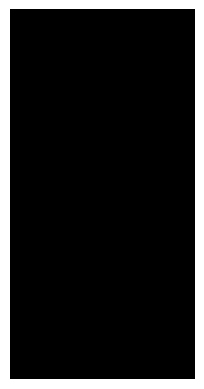

In [5]:
segmentation_mask = model.predict(input_person_image)

# Assuming you have a class index for the body parts you are interested in
# Adjust the class index according to your specific task
body_part_class_index = 2

# Create a binary mask for the body part class
binary_mask = (segmentation_mask[0, :, :, body_part_class_index] > 0.5).astype(np.float32)  # Adjust the threshold as needed

# Convert the binary mask to a color image for overlaying
segmented_image = cv2.cvtColor(binary_mask, cv2.COLOR_GRAY2BGR)

# Overlay the segmented image on the original input image
overlay_image = cv2.addWeighted(input_person_image[0], 0.7, segmented_image, 0.3, 0, dtype=cv2.CV_32F)

# Display the overlay image using matplotlib
plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

1/1 [==============================] - 1s 1s/step


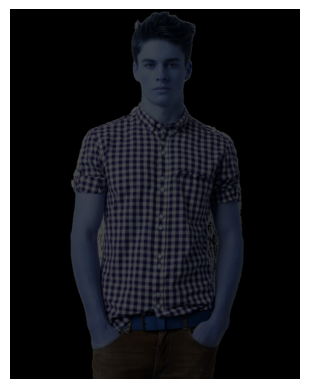

In [14]:
segmentation_mask = model.predict(input_person_image)

# Assuming you have a class index for the body parts you are interested in
# Adjust the class index according to your specific task
body_part_class_index = 5

# Create a binary mask for the body part class
binary_mask = (segmentation_mask[0, :, :, body_part_class_index] > 0.5).astype(np.float32)  # Adjust the threshold as needed

# Convert the binary mask to a color image for overlaying
segmented_image = cv2.cvtColor(binary_mask, cv2.COLOR_GRAY2BGR)

# Overlay the segmented image on the original input image
overlay_image = cv2.addWeighted(input_person_image[0], 0.3, segmented_image, 0.7, 0, dtype=cv2.CV_32F)
overlay_image = cv2.resize(overlay_image, dsize=[1024, 1309])

# Display the overlay image using matplotlib
plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()